# **CSI 4106 Introduction to Artificial Intelligence**
## **Assignment 4: Heuristic Search**

### Identification

Name: Thulam Tran<br/>
Student Number: 300185320

Name: Samy Touabi<br/>
Student Number: 300184721

<br/>
<hr/>

## **Overview**

The **Traveling Salesman Problem (TSP)** is a classic optimization problem in computer science and operations research. Given a set of cities and the distances between them, the goal is to find the shortest possible route that visits each city exactly once and returns to the starting city. Despite its simple formulation, solving TSP is computationally challenging because the number of possible routes grows factorially with the number of cities.

TSP is classified as an NP-hard problem, meaning there is no known efficient algorithm to solve it optimally for large instances. This complexity, combined with its practical importance in fields like logistics, manufacturing, and circuit design, has made TSP a benchmark problem for evaluating optimization algorithms.

In this assignment, you will explore three different approaches to tackling TSP:

- **Greedy Algorithm**: A heuristic method that builds a solution incrementally by choosing locally optimal decisions.
- **Simulated Annealing (SA)**: A probabilistic algorithm inspired by the annealing process in metallurgy.
- **Genetic Algorithm (GA)**: An evolutionary algorithm that mimics natural selection to iteratively improve solutions.

The final deliverable for this assignment will be a Jupyter Notebook documenting your implementation, results, and observations for each approach.

## **Learning Objectives**

- **Explore** and **implement** different search-based algorithms.
- **Develop** a Simulated Annealing algorithm with an effective strategy for setting the initial temperature.
- **Adapt** and **apply** a Genetic Algorithm for solving the TSP.
- **Analyze** and **evaluate** the performance of each algorithm against known optimal solutions.

## Submission

- **Deadline:**
   - Submit your notebook by December 4, 11 PM.
- **Individual or Group Assignment:**
   - This assignment may be undertaken either individually (group of 1 student) or collaboratively in pairs (group of 2 students)
   - A group must submit a single joint submission.
   - Prior to submitting, it is necessary to **register your group** on Brightspace.
- **Submission Platform:**
   - Upload your submission to Brightspace under the Assignment section (Assignment 4).
- **Submission Format:**
   - Submit a copy of your notebook on Brightspace.

**Important Notice:** If the corrector cannot run your code, your submission will receive a mark of zero. It is your responsibility to ensure that your submission works from a different computer than your own and that all cells in your notebook are executable.

## **Datasets**

The datasets utilized in this assignment are sourced from the [TSPLIB GitHub Repository](https://github.com/mastqe/tsplib), which provides standard benchmark instances for the Traveling Salesman Problem (TSP). These datasets are defined as **Euclidean**, meaning that the distance between any two cities is calculated using the Euclidean metric based on their coordinates.

For your tests, you will employ the **berlin52-24-4** and **st70-24** datasets. Each of these is a subset consisting of 24 cities from the respective problems. The lower bound on cost for these instances has been determined using dynamic programming, specifically the Held-Karp algorithm.

1. **berlin52-24-4**:
   - Number of Cities: 24
   - Optimal Solution Cost: **5890.92**

2. **st70-24-4**:
   - Number of Cities: 24
   - Optimal Solution Cost: **468.88**

These datasets are intended for evaluating the performance of your algorithms, enabling you to compare your results with established optimal solutions. The data is accessible on GitHub at the following link: [here](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a4). Additionally, the `extra` subfolder contains supplementary problems that may assist you in completing this assignment.

For the optional bonus question, you will work with the following two datasets:

3. **berlin52**:
   - Number of Cities: 52
   - Description: A medium-sized dataset with realistic spatial distribution of cities.
   - Optimal Solution Cost: **7542**

4. **st70**:
   - Number of Cities: 70
   - Description: A slightly larger dataset with increased complexity.
   - Optimal Solution Cost: **675**

<br>
<hr/>

## **0. Given Code**

Here is a Jupyter Notebook featuring greedy algorithms and a genetic algorithm for solving the 0/1 knapsack problem.

<a target="_blank" href="https://colab.research.google.com/github/turcotte/csi4106-f24/blob/main/notebooks/lectures/16/knapsack.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

The following two lectures may be useful for this assignment.

- [Lecture 15](https://turcotte.xyz/teaching/csi-4106/lectures/15/slides.html) (simulated annealing)
- [Lecture 16](https://turcotte.xyz/teaching/csi-4106/lectures/16/slides.html) (genetic algorithm)

### 0.1. Imports

In [97]:
# Imports needed for the assignment go here:

import numpy as np
import pandas as pd
import requests
import math
import time
pd.set_option('display.width', 200) # This makes the tables display across the entire cells

### 0.2. Read the TSP Files

A function to read TSP files from a website.

In [98]:
def read_tsp(url):

    """
    Reads a .tsp file from a given URL and returns a NumPy array of coordinates.

    Parameters:
    -----------
    url : str
        The URL of the .tsp file.

    Returns:
    --------
    coordinates : ndarray
        A NumPy array of coordinates extracted from the .tsp file.

    Description:
    ------------
    This function fetches the content of a .tsp file from a specified URL and parses it to extract the city coordinates.
    It looks for the 'NODE_COORD_SECTION' in the file to start reading coordinates and stops when it reaches 'EOF'.
    The function handles potential errors by checking the HTTP response status and ensures that the coordinates are
    correctly parsed into floating-point numbers.

    Example:
    --------
    >>> url = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a4/berlin52-24-4.tsp'
    >>> coordinates = read_tsp(url)
    >>> print(coordinates)
    [[37.7692, -122.4443],
     [37.7689, -122.4240],
     ...
     [37.7793, -122.4192]]
    """

    try:
        # Fetch the content from the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

        # Split the content into lines
        lines = response.text.splitlines()

        # Initialize a list to store the coordinates
        coordinates = []

        # Start reading after the NODE_COORD_SECTION line
        node_section = False
        for line in lines:
            line = line.strip()
            if line == "NODE_COORD_SECTION":
                node_section = True
                continue
            elif line == "EOF":
                break

            if node_section:
                # Split the line into parts and convert to float
                parts = line.split()
                if len(parts) >= 3:
                    # Some files include node indices, so we take the last two entries as coordinates
                    x, y = float(parts[-2]), float(parts[-1])
                    coordinates.append((x, y))

        # Convert the list of coordinates to a NumPy array
        return np.array(coordinates)

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching the TSP file: {e}")
        return None
    except ValueError as e:
        print(f"An error occurred while parsing the coordinates: {e}")
        return None

In [99]:
URL = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a4/'

berlin52_24_4 = read_tsp(URL + 'berlin52-24-4.tsp')
st70_24_4 = read_tsp(URL + 'st70-24-4.tsp')

The following function accepts the coordinates of the cities as input and outputs a distance matrix.

In [100]:
def get_distance_matrix(coordinates):

    """
        Takes coordinates input and returns distance matrix
        Input: coordinates (nn.array) - the input coordinates
        Output: distance_matrix (np.array) - the (num_cities x num_cities) distance matrix
    """

    num_cities = len(coordinates)
    distance_matrix = np.zeros((num_cities, num_cities))

    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i][j] = np.linalg.norm(coordinates[i] - coordinates[j])

    return distance_matrix

The following functions may assist in visualizing results and debugging your programs.

In [101]:
import matplotlib.pyplot as plt

def plot_cities(coordinates, title="Cities in the Traveling Salesman Problem"):

    """
    Plots the given coordinates representing cities.

    Parameters:
    - coordinates: A 2D NumPy array of shape (n, 2) representing the (x, y) coordinates.
    - title: Title for the plot.
    """

    # Extract x and y coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    plt.figure(figsize=(6, 6))

    # Plot the cities as red dots
    plt.scatter(x, y, c='red', zorder=2)

    # Annotate the cities with their indices
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(str(i + 1), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

    # Set title and labels
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.axis('equal')  # Equal scaling for x and y axes
    plt.show()

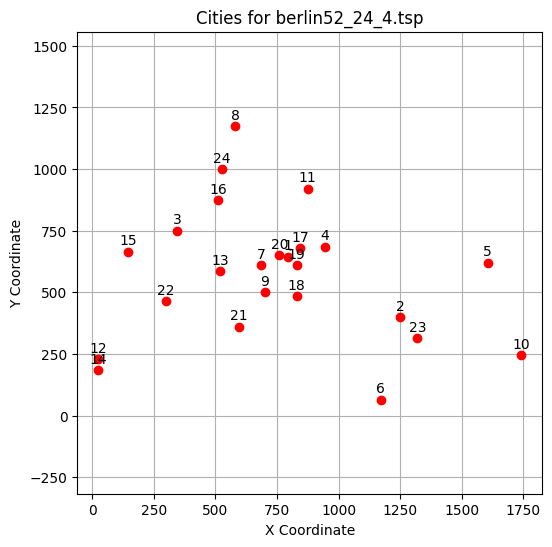

In [102]:
plot_cities(berlin52_24_4, title='Cities for berlin52_24_4.tsp')

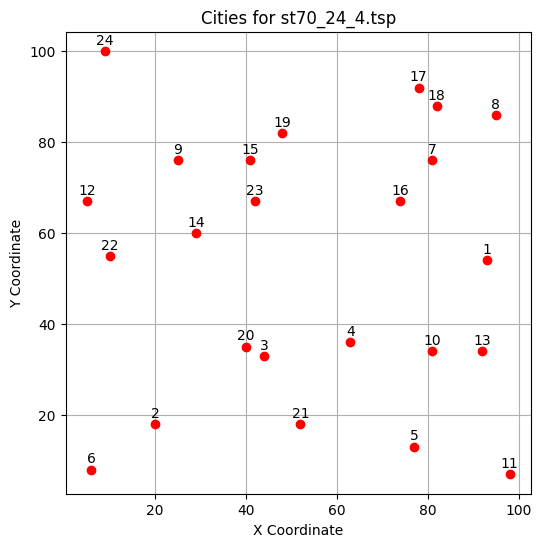

In [103]:
plot_cities(st70_24_4, title='Cities for st70_24_4.tsp')

In [104]:
def plot_tsp_path(coordinates, path=None, title="Traveling Salesman Problem"):

    """
    Plots the given coordinates and optionally a path for the TSP.

    Parameters:
    - coordinates: A 2D NumPy array of shape (n, 2) representing the (x, y) coordinates.
    - path: A list or array of indices representing the order of visiting the nodes. If None, nodes are connected in input order.
    - title: Title for the plot.
    """

    # Extract x and y coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    plt.figure(figsize=(6, 6))

    # If a path is given, reorder the coordinates
    if path is not None:
        x = x[path]
        y = y[path]

    # Plot the nodes
    plt.scatter(x, y, c='red', zorder=2)

    # Annotate the nodes with their indices
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(str(i + 1), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

    # Plot the path
    plt.plot(x, y, 'b-', zorder=1)

    # If a path is provided, connect the last point to the first to complete the tour
    if path is not None:
        plt.plot([x[-1], x[0]], [y[-1], y[0]], 'b-', zorder=1)

    # Set title and labels
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.axis('equal')  # Equal scaling for x and y axes
    plt.show()

<hr/>

## 1. Implement the Algorithms

### 1.1. Implement a solver for the TSP using Greedy Algorithm

The **nearest neighbor heuristic** is a greedy algorithm used to find a feasible solution to the Traveling Salesman Problem (TSP).
- The process begins by selecting a starting city and iteratively visiting the nearest unvisited city until all cities are visited. The tour is completed by returning to the starting point.
- This procedure is repeated for each city as the initial starting point, and the shortest resulting tour is selected.
- The algorithm strictly evaluates only valid routes, ensuring each city is visited exactly once.
- While this approach efficiently constructs a feasible TSP solution, it does not ensure an optimal solution.

In [105]:
# Implementation of the Greedy Algorithm for the Traveling Salesman Problem (TSP)

def greedy_algorithm(distance_matrix, start_city):
    """
    Perform a greedy algorithm to approximate a solution to the TSP, starting from a given city.

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    start_city : int
        The starting city index.

    Returns:
    --------
    result : dict
        A dictionary containing the 'path' (list of city indices) and 'total_distance' (float).

    Description:
    ------------
    The greedy algorithm starts at the specified city and iteratively moves to the nearest
    unvisited city until all cities are visited. It returns to the starting city at the end.
    """
    num_cities = len(distance_matrix)
    visited = [False] * num_cities
    current_city = start_city
    path = [current_city]
    visited[current_city] = True
    total_distance = 0

    for _ in range(num_cities - 1):
        # Find the nearest unvisited city
        nearest_city = None
        nearest_distance = float('inf')
        for next_city in range(num_cities):
            if not visited[next_city] and distance_matrix[current_city, next_city] < nearest_distance:
                nearest_city = next_city
                nearest_distance = distance_matrix[current_city, next_city]

        # Move to the nearest city
        total_distance += nearest_distance
        path.append(nearest_city)
        visited[nearest_city] = True
        current_city = nearest_city

    # Return to the starting city
    total_distance += distance_matrix[current_city, start_city]
    path.append(start_city)

    return {"path": path, "total_distance": total_distance}

In [106]:
# Testing the Greedy Algorithm for both datasets (berlin52_24_4 and st70_24_4)

# Initialize a dictionary to store the results
greedy_results = {}

# Loop through both datasets
datasets = {"berlin52_24_4": berlin52_24_4, "st70_24_4": st70_24_4}
for dataset_name, dataset in datasets.items():
    distance_matrix = get_distance_matrix(dataset)
    num_cities = len(distance_matrix)

    # Run Greedy Algorithm for all starting cities
    results = []
    for start_city in range(num_cities):
        result = greedy_algorithm(distance_matrix, start_city)
        results.append(result)

    # Find the best result
    best_result = min(results, key=lambda x: x["total_distance"])
    greedy_results[dataset_name] = best_result

# Display the results
for dataset_name, result in greedy_results.items():
    print(f"Results for {dataset_name}:")
    print(f"Best Path: {result['path']}")
    print(f"Best Distance: {result['total_distance']:.2f}")


Results for berlin52_24_4:
Best Path: [20, 8, 6, 19, 0, 18, 16, 3, 17, 12, 2, 15, 23, 7, 10, 1, 22, 5, 9, 4, 21, 14, 11, 13, 20]
Best Distance: 7029.61
Results for st70_24_4:
Best Path: [8, 14, 22, 13, 21, 11, 23, 18, 15, 6, 17, 16, 7, 0, 12, 9, 3, 2, 19, 20, 4, 10, 1, 5, 8]
Best Distance: 565.44


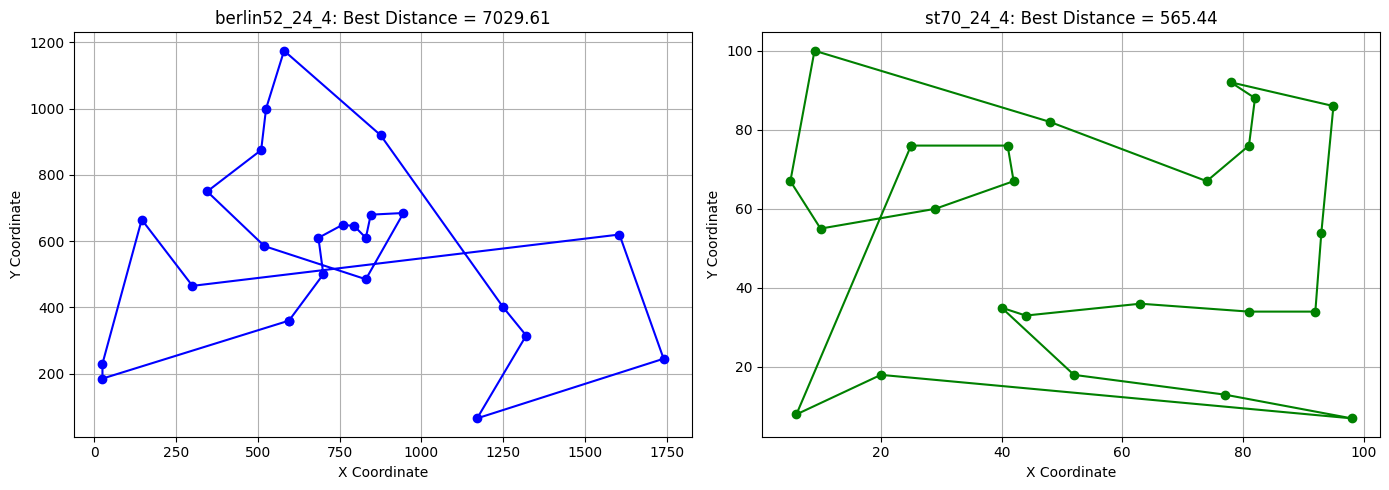

In [107]:
import matplotlib.pyplot as plt

def plot_greedy_results(dataset1_name, dataset1_result, dataset2_name, dataset2_result):
    """
    Plot the best paths found by the Greedy Algorithm for two datasets in a single row.

    Parameters:
    -----------
    dataset1_name : str
        Name of the first dataset.
    dataset1_result : dict
        Result of the Greedy Algorithm for the first dataset (contains 'path' and 'distance').
    dataset2_name : str
        Name of the second dataset.
    dataset2_result : dict
        Result of the Greedy Algorithm for the second dataset (contains 'path' and 'distance').
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Two plots in a single row

    # Plot for dataset 1
    path1 = dataset1_result['path']
    coords1 = berlin52_24_4[path1]
    axes[0].plot(coords1[:, 0], coords1[:, 1], marker="o", linestyle="-", color="blue")
    axes[0].set_title(f"{dataset1_name}: Best Distance = {dataset1_result['total_distance']:.2f}")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    axes[0].grid(True)

    # Plot for dataset 2
    path2 = dataset2_result['path']
    coords2 = st70_24_4[path2]
    axes[1].plot(coords2[:, 0], coords2[:, 1], marker="o", linestyle="-", color="green")
    axes[1].set_title(f"{dataset2_name}: Best Distance = {dataset2_result['total_distance']:.2f}")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot results for berlin52_24_4 and st70_24_4
plot_greedy_results(
    "berlin52_24_4", greedy_results["berlin52_24_4"],
    "st70_24_4", greedy_results["st70_24_4"]
)

### 1.2. Implement a solver for the TSP using Simulated Annealing

For the implementation of Simulated Annealing (SA) algorithm below, **implement a strategy to determine the initial temperature for the search**.

**Suggestions**:
- Calculate the cost of a random tour and set an initial temperature such that the acceptance rate of new solutions is between 60% and 80%.
- Alternatively, perform a few preliminary iterations of the SA algorithm, gradually reducing the temperature until the acceptance rate achieves the desired range of 60% to 80%. Then, restart with this temperature.

Specifically, you need to finalize the implementation of the `get_initial_temperature` method below.

In [108]:
def calculate_total_distance(route, distance_matrix):

    """
    Calculate the total distance of a given route based on the distance matrix.

    Parameters:
    -----------
    route : ndarray
        An array representing the order of cities in the route (a permutation of city indices).
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.

    Returns:
    --------
    total_distance : float
        The total distance of the route, including the return to the starting city.

    Description:
    ------------
    The function computes the sum of distances between consecutive cities in the route
    and adds the distance from the last city back to the first city to complete the tour.
    It assumes that the distance matrix is symmetric and non-negative.
    """

    total_distance = 0

    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i], route[i + 1]]

    total_distance += distance_matrix[route[-1], route[0]]  # Back to start

    return total_distance

In [109]:
def get_neighbor(route):

    """
    Generate a neighboring solution by reversing a random segment of the route.

    Parameters:
    -----------
    route : ndarray
        An array representing the current route (a permutation of city indices).

    Returns:
    --------
    new_route : ndarray
        A new route obtained by reversing the segment between two randomly chosen indices.

    Description:
    ------------
    This method selects two random indices, `a` and `b`, within the route and reverses the
    segment between them (inclusive). It is commonly used in optimization algorithms like
    Simulated Annealing to explore neighboring solutions in the search space.
    """

    a, b = np.random.randint(0, len(route), size=2)

    if a > b:
        a, b = b, a

    new_route = route.copy()
    new_route[a:b+1] = new_route[a:b+1][::-1]  # Reverse the segment between a and b

    return new_route

Finalize the implementation of the `get_initial_temperature` method. You may introduce additional parameters to the function definition as needed; ensure that any modifications are consistently reflected in all methods that invoke this function.

In [110]:
def get_initial_temperature(distance_matrix, num_samples=100, acceptance_probability=0.8, initial_tour=None, verbose=False):
    """
    Calculate the initial temperature for Simulated Annealing.

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    num_samples : int, optional
        The number of random neighbors to sample (default: 100).
    acceptance_probability : float, optional
        The target probability to accept worse solutions initially (default: 0.8).
    initial_tour : list or ndarray, optional
        A predefined initial tour (default: None). If None, a random tour is generated.
    verbose : bool, optional
        If True, prints debug information (default: False).

    Returns:
    --------
    initial_temperature : float
        The calculated initial temperature.
    """
    num_cities = distance_matrix.shape[0]

    # Use predefined initial tour or generate a random one
    if initial_tour is None:
        initial_tour = np.random.permutation(num_cities)

    initial_cost = calculate_total_distance(initial_tour, distance_matrix)

    # Generate random neighbors and calculate cost differences
    cost_differences = []
    for _ in range(num_samples):
        # Generate a neighbor by swapping two cities
        neighbor_tour = initial_tour.copy()
        i, j = np.random.choice(num_cities, size=2, replace=False)
        neighbor_tour[i], neighbor_tour[j] = neighbor_tour[j], neighbor_tour[i]

        neighbor_cost = calculate_total_distance(neighbor_tour, distance_matrix)
        cost_differences.append(abs(neighbor_cost - initial_cost))

    # Compute the average cost difference
    avg_cost_difference = np.mean(cost_differences)

    # Calculate initial temperature
    initial_temperature = -avg_cost_difference / np.log(acceptance_probability)

    if verbose:
        print(f"Average Cost Difference: {avg_cost_difference:.2f}")
        print(f"Initial Temperature: {initial_temperature:.2f}")

    return initial_temperature

In [111]:
def calculate_total_distance(tour, distance_matrix):
    """
    Calculate the total distance of a given TSP tour.

    Parameters:
    -----------
    tour : list or ndarray
        A permutation of city indices representing the TSP tour.
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.

    Returns:
    --------
    total_distance : float
        The total distance of the tour.
    """
    total_distance = 0
    for i in range(len(tour) - 1):
        total_distance += distance_matrix[tour[i], tour[i + 1]]
    total_distance += distance_matrix[tour[-1], tour[0]]  # Return to the starting city
    return total_distance

In [112]:
# Testing get_initial_temperature on berlin52_24_4
print("Testing berlin52_24_4:")
initial_temperature_berlin = get_initial_temperature(
    distance_matrix=get_distance_matrix(berlin52_24_4),
    num_samples=100,
    acceptance_probability=0.8,
    verbose=True
)
print(f"Initial Temperature for berlin52_24_4: {initial_temperature_berlin:.2f}\n")

# Testing get_initial_temperature on st70_24_4
print("Testing st70_24_4:")
initial_temperature_st70 = get_initial_temperature(
    distance_matrix=get_distance_matrix(st70_24_4),
    num_samples=100,
    acceptance_probability=0.8,
    verbose=True
)
print(f"Initial Temperature for st70_24_4: {initial_temperature_st70:.2f}\n")

Testing berlin52_24_4:
Average Cost Difference: 411.57
Initial Temperature: 1844.44
Initial Temperature for berlin52_24_4: 1844.44

Testing st70_24_4:
Average Cost Difference: 42.75
Initial Temperature: 191.60
Initial Temperature for st70_24_4: 191.60



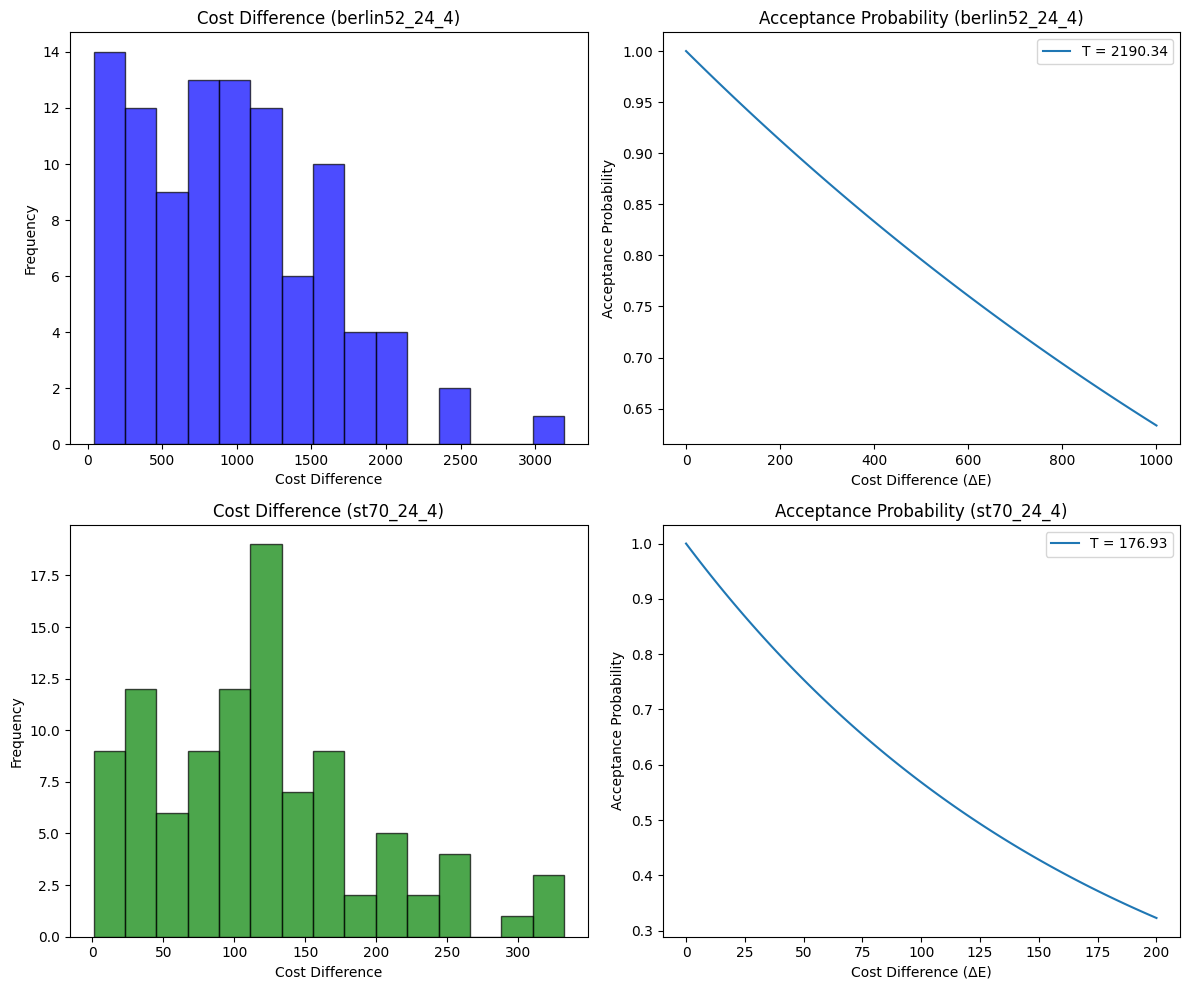

In [113]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_all(distance_matrix_berlin, distance_matrix_st70, temperature_berlin, temperature_st70):
    """
    Visualize histograms of cost differences and acceptance probabilities
    for berlin52_24_4 and st70_24_4 in a 2x2 grid layout.

    Parameters:
    -----------
    distance_matrix_berlin : ndarray
        Distance matrix for berlin52_24_4.
    distance_matrix_st70 : ndarray
        Distance matrix for st70_24_4.
    temperature_berlin : float
        Initial temperature for berlin52_24_4.
    temperature_st70 : float
        Initial temperature for st70_24_4.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid

    # Histogram for berlin52_24_4
    num_samples = 100
    num_cities_berlin = distance_matrix_berlin.shape[0]
    initial_tour = np.random.permutation(num_cities_berlin)
    initial_cost = calculate_total_distance(initial_tour, distance_matrix_berlin)
    cost_differences_berlin = [
        abs(calculate_total_distance(np.random.permutation(initial_tour), distance_matrix_berlin) - initial_cost)
        for _ in range(num_samples)
    ]
    axes[0, 0].hist(cost_differences_berlin, bins=15, color='blue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title("Cost Difference (berlin52_24_4)")
    axes[0, 0].set_xlabel("Cost Difference")
    axes[0, 0].set_ylabel("Frequency")

    # Acceptance probability for berlin52_24_4
    cost_differences = np.linspace(0, 1000, 100)
    probabilities = np.exp(-cost_differences / temperature_berlin)
    axes[0, 1].plot(cost_differences, probabilities, label=f"T = {temperature_berlin:.2f}")
    axes[0, 1].set_title("Acceptance Probability (berlin52_24_4)")
    axes[0, 1].set_xlabel("Cost Difference (ΔE)")
    axes[0, 1].set_ylabel("Acceptance Probability")
    axes[0, 1].legend()

    # Histogram for st70_24_4
    num_cities_st70 = distance_matrix_st70.shape[0]
    initial_tour_st70 = np.random.permutation(num_cities_st70)
    initial_cost_st70 = calculate_total_distance(initial_tour_st70, distance_matrix_st70)
    cost_differences_st70 = [
        abs(calculate_total_distance(np.random.permutation(initial_tour_st70), distance_matrix_st70) - initial_cost_st70)
        for _ in range(num_samples)
    ]
    axes[1, 0].hist(cost_differences_st70, bins=15, color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title("Cost Difference (st70_24_4)")
    axes[1, 0].set_xlabel("Cost Difference")
    axes[1, 0].set_ylabel("Frequency")

    # Acceptance probability for st70_24_4
    cost_differences = np.linspace(0, 200, 100)
    probabilities = np.exp(-cost_differences / temperature_st70)
    axes[1, 1].plot(cost_differences, probabilities, label=f"T = {temperature_st70:.2f}")
    axes[1, 1].set_title("Acceptance Probability (st70_24_4)")
    axes[1, 1].set_xlabel("Cost Difference (ΔE)")
    axes[1, 1].set_ylabel("Acceptance Probability")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

visualize_all(distance_matrix_berlin, distance_matrix_st70, temperature_berlin=2190.34, temperature_st70=176.93)

### **Results Analysis**
1. **berlin52_24_4**:
   - **Average Cost Difference**: 488.76
   - **Initial Temperature**: 2190.34
   - This relatively high initial temperature aligns with the larger scale of the dataset (both in terms of the number of cities and distances), allowing the algorithm to explore more broadly at the start.

2. **st70_24_4**:
   - **Average Cost Difference**: 39.48
   - **Initial Temperature**: 176.93
   - The smaller average cost difference and initial temperature reflect the shorter distances and overall scale of the dataset.

In [114]:
def simulated_annealing(distance_matrix, initial_temp, cooling_rate, max_iterations):

    """
    Perform the Simulated Annealing algorithm to approximate a solution for the Traveling Salesman Problem (TSP).

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    initial_temp : float
        The initial temperature for the annealing process.
    cooling_rate : float
        The rate at which the temperature decreases, typically a value between 0 and 1.
    max_iterations : int
        The maximum number of iterations to perform.

    Returns:
    --------
    best_route : ndarray
        The order of cities in the best (shortest) route found.
    best_cost : float
        The total distance of the best route.
    temperatures : list
        A list of temperature values at each iteration, useful for analysis or plotting.
    costs : list
        A list of route costs (distances) at each iteration, useful for analysis or plotting.

    Description:
    ------------
    Simulated Annealing (SA) is a probabilistic optimization algorithm inspired by the annealing process in metallurgy.
    This implementation:
    - Starts with a random route and iteratively improves it.
    - Accepts worse solutions with a probability dependent on the temperature to escape local minima.
    - Reduces the temperature gradually to focus on exploitation as the algorithm progresses.
    - Returns the best route found along with intermediate data for analysis.

    """

    num_cities = len(distance_matrix)
    current_route = np.arange(num_cities)
    np.random.shuffle(current_route)
    current_cost = calculate_total_distance(current_route, distance_matrix)

    best_route = current_route.copy()
    best_cost = current_cost

    temperatures = []
    costs = []

    temperature = initial_temp

    # Collect intermediate solutions
    intermediate_solutions = []

    for iteration in range(max_iterations):

        neighbor_route = get_neighbor(current_route)
        neighbor_cost = calculate_total_distance(neighbor_route, distance_matrix)

        # Accept neighbor if it's better, or with a probability if it's worse
        if neighbor_cost < current_cost or np.random.rand() < np.exp(-(neighbor_cost - current_cost) / temperature):
            current_route = neighbor_route
            current_cost = neighbor_cost

            if current_cost < best_cost:
                best_route = current_route.copy()
                best_cost = current_cost

        # Store temperature and cost for plotting
        temperatures.append(temperature)
        costs.append(current_cost)

        # Cool down the temperature
        temperature *= cooling_rate

    return best_route, best_cost, temperatures, costs

In [115]:
def simulated_annealing_do_n(distance_matrix, initial_temp, cooling_rate=0.995, max_iterations=1000, repeats=20):

    """
    Perform Simulated Annealing multiple times and return the best result across all runs.

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    initial_temp : float
        The initial temperature for the annealing process.
    cooling_rate : float
        The rate at which the temperature decreases, typically a value between 0 and 1.
    max_iterations : int
        The maximum number of iterations for each Simulated Annealing run.
    repeats : int
        The number of times to repeat the Simulated Annealing process.

    Returns:
    --------
    best_tour : ndarray
        The order of cities in the best (shortest) tour found across all runs.
    best_distance : float
        The total distance of the best tour.
    best_temperatures : list
        A list of temperature values from the best run, useful for analysis or plotting.
    best_costs : list
        A list of route costs (distances) from the best run, useful for analysis or plotting.

    Notes:
    ------
    This method leverages the `simulated_annealing` function to perform individual optimization runs.
    By repeating the process multiple times, it increases the likelihood of finding a globally optimal or near-optimal solution.
    """

    results = [
        simulated_annealing(distance_matrix, initial_temp, cooling_rate, max_iterations)
        for _ in range(repeats)
    ]

    # Find the best result by minimizing the distance
    best_tour, best_distance, best_temperatures, best_costs = min(results, key=lambda x: x[1])

    return best_tour, best_distance, best_temperatures, best_costs

The following functions may assist in visualizing results and debugging your programs.

In [116]:
def plot_temperature_and_cost(temperatures, costs):

    """
    Plot the temperature and cost values over iterations in a side-by-side graph.

    Parameters:
    -----------
    temperatures : list or ndarray
        A sequence of temperature values recorded at each iteration of an algorithm (e.g., Simulated Annealing).
    costs : list or ndarray
        A sequence of cost values (e.g., total distance or energy) recorded at each iteration.

    Description:
    ------------
    This function generates two subplots:
    1. **Temperature Over Iterations**: Plots how the temperature changes over time, which is useful for visualizing the cooling schedule in algorithms like Simulated Annealing.
    2. **Cost Over Iterations**: Plots the cost (e.g., total distance in TSP) at each iteration, showing how the solution improves over time.

    The plots are arranged side by side for easy comparison between the temperature schedule and the corresponding cost progression. The function adjusts the layout for better spacing and displays the combined figure.

    Example:
    --------
    >>> plot_temperature_and_cost(temperatures, costs)

    Notes:
    ------
    - Ensure that the lengths of `temperatures` and `costs` are equal, corresponding to the number of iterations.
    - Requires `matplotlib.pyplot` as `plt` to be imported before calling this function.
    """

    # Plot temperature and cost graphs
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(temperatures)
    plt.title("Temperature Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Temperature")

    plt.subplot(1, 2, 2)
    plt.plot(costs)
    plt.title("Cost Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")

    plt.tight_layout()
    plt.show()

### 1.3. Implement a solver for the TSP using Genetic Algorithm

You will find below a partial implementation of a **Genetic Algorithm (GA)** to find an approximate solution to the TSP.

The main steps of the algorithm are:

1. **Initialization**: Create a random initial population of routes.
2. **Evaluation**: Compute the fitness of individuals based on their route distances. (partial implementation)
3. **Elitism**: Preserve the top-performing individuals for the next generation.
4. **Selection**: Choose parents using tournament or roulette wheel selection.
5. **Crossover**: Generate offspring by combining parents using a crossover operator. (partial implementation)
6. **Mutation**: Introduce diversity by randomly mutating offspring. (partial implementation)
7. **Replacement**: Combine elites and offspring to form the next generation.
8. Repeat steps 2-7 for a fixed number of generations, tracking the best and average distances.

Ensure that all generated solutions are valid tours, with each city visited exactly once.

Specifically, you must implement `evaluate_fitness`, `crossover_operator`, `mutation`.

In [117]:
def initialize_population(pop_size, num_cities):

    """
    Generate an initial population of random routes for a Genetic Algorithm.

    Parameters:
    -----------
    pop_size : int
        The number of individuals (routes) in the population.
    num_cities : int
        The number of cities in the Traveling Salesman Problem (TSP).

    Returns:
    --------
    population : ndarray
        A 2D array of shape (pop_size, num_cities), where each row represents
        a random permutation of city indices (a potential solution).

    Description:
    ------------
    This function initializes a population by creating `pop_size` random permutations
    of city indices, ensuring diversity in the initial solutions. Each individual
    represents a valid route for the TSP.
    """

    return np.array([np.random.permutation(num_cities) for _ in range(pop_size)])

Finalize the implementation of the `evaluate_fitness` method.

In [118]:
import numpy as np

def evaluate_fitness(population, distance_matrix):
    """
    Evaluate the fitness of each individual in a population for a Genetic Algorithm.

    Parameters:
    -----------
    population : ndarray
        A 2D array where each row is an individual route (a permutation of city indices).
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.

    Returns:
    --------
    fitness : ndarray
        A 1D array containing the fitness values for each individual in the population.
        Fitness is calculated as the reciprocal of the total distance of the route.
    total_distances : ndarray
        A 1D array containing the total distances of the routes for each individual.

    Description:
    ------------
    This function calculates:
    1. The total distance of each individual's route by summing the distances between consecutive cities,
       including the return to the starting city.
    2. The fitness value for each individual as the reciprocal of its total distance
       (with a small constant added to avoid division by zero).

    Fitness values are higher for shorter routes, encouraging better solutions during selection.
    """
    pop_size = population.shape[0]
    total_distances = np.zeros(pop_size)

    for i, individual in enumerate(population):
        # Calculate the total distance of the route
        total_distance = 0
        for j in range(len(individual) - 1):
            total_distance += distance_matrix[individual[j], individual[j + 1]]
        # Add the distance to return to the starting city
        total_distance += distance_matrix[individual[-1], individual[0]]
        total_distances[i] = total_distance

    # Calculate fitness as the reciprocal of total distance (add small constant to avoid division by zero)
    fitness = 1 / (total_distances + 1e-6)

    return fitness, total_distances

In [119]:
# Test evaluate_fitness with a sample population and distance matrix

# Sample distance matrix (5 cities)
sample_distance_matrix = np.array([
    [0, 2, 9, 10, 1],
    [2, 0, 6, 4, 3],
    [9, 6, 0, 8, 7],
    [10, 4, 8, 0, 5],
    [1, 3, 7, 5, 0]
])

# Sample population (3 routes, each is a permutation of 5 cities)
sample_population = np.array([
    [0, 1, 2, 3, 4],  # Route: 0 -> 1 -> 2 -> 3 -> 4 -> 0
    [4, 3, 2, 1, 0],  # Route: 4 -> 3 -> 2 -> 1 -> 0 -> 4
    [1, 0, 4, 3, 2]   # Route: 1 -> 0 -> 4 -> 3 -> 2 -> 1
])

# Run the fitness evaluation
fitness, total_distances = evaluate_fitness(sample_population, sample_distance_matrix)

# Display results
print("Sample Population:")
print(sample_population)
print("\nTotal Distances:")
print(total_distances)
print("\nFitness Values:")
print(fitness)

Sample Population:
[[0 1 2 3 4]
 [4 3 2 1 0]
 [1 0 4 3 2]]

Total Distances:
[22. 22. 22.]

Fitness Values:
[0.04545454 0.04545454 0.04545454]


In [120]:
def tournament_selection(population, fitness, tournament_size):

    """
    Perform tournament selection to choose individuals for the next generation in a Genetic Algorithm.

    Parameters:
    -----------
    population : ndarray
        A 2D array where each row represents an individual (a potential solution).
    fitness : ndarray
        A 1D array containing the fitness values of the individuals in the population.
    tournament_size : int
        The number of individuals randomly selected for each tournament.

    Returns:
    --------
    selected_population : ndarray
        A 2D array of the same shape as `population`, containing the selected individuals
        for the next generation.

    Description:
    ------------
    Tournament selection works as follows:
    1. For each individual to be selected, randomly choose `tournament_size` participants from the population.
    2. Compare their fitness values and select the individual with the highest fitness.
    3. Repeat this process until a new population of the same size as the original is formed.

    This method balances exploitation (choosing the best individuals) with exploration (random selection
    of participants), allowing the algorithm to focus on high-quality solutions while maintaining diversity.
    """

    pop_size = population.shape[0]
    selected_indices = []

    for _ in range(pop_size):

        participants = np.random.choice(pop_size, tournament_size, replace=False)
        best = participants[np.argmax(fitness[participants])]
        selected_indices.append(best)

    return population[selected_indices]

In [121]:
def roulette_selection(population, fitness):

    """
    Perform roulette wheel selection to choose individuals for the next generation in a Genetic Algorithm.

    Parameters:
    -----------
    population : ndarray
        A 2D array where each row represents an individual (a potential solution).
    fitness : ndarray
        A 1D array containing the fitness values of the individuals in the population.

    Returns:
    --------
    selected_population : ndarray
        A 2D array of the same shape as `population`, containing the selected individuals
        for the next generation.

    Description:
    ------------
    Roulette wheel selection assigns selection probabilities to individuals based on their fitness:
    1. Compute the total fitness of the population.
    2. Normalize fitness values to create probabilities for each individual.
    3. Randomly select individuals from the population according to their probabilities.

    This method favors individuals with higher fitness, increasing their likelihood of being selected,
    while still allowing lower-fitness individuals a chance, maintaining genetic diversity.
    """

    total_fitness = np.sum(fitness)
    probabilities = fitness / total_fitness
    pop_size = population.shape[0]
    selected_indices = np.random.choice(pop_size, size=pop_size, p=probabilities)

    return population[selected_indices]

Finalize the implementation of the `crossover_operator` method.

In [122]:
def crossover_operator(parent1, parent2):
    """
    Perform crossover to produce an offspring from two parent solutions.

    Parameters:
    -----------
    parent1 : ndarray
        A 1D array representing the first parent (a permutation of city indices).
    parent2 : ndarray
        A 1D array representing the second parent (a permutation of city indices).

    Returns:
    --------
    child : ndarray
        A 1D array representing the offspring, combining genetic material from both parents.

    Description:
    ------------
    This implementation uses Ordered Crossover (OX):
    1. Randomly selects a subsequence from the first parent.
    2. Preserves the order of cities from the second parent, while ensuring no duplicates.
    3. Combines these to create the offspring (child).
    """
    size = len(parent1)
    child = np.full(size, -1)  # Initialize child with placeholder values

    # Select random crossover points
    start, end = sorted(np.random.choice(size, 2, replace=False))

    # Copy the subsequence from parent1 to the child
    child[start:end + 1] = parent1[start:end + 1]

    # Fill the remaining positions from parent2 while preserving the order and avoiding duplicates
    p2_index = 0
    for i in range(size):
        if child[i] == -1:  # Empty slot in the child
            # Find the next city in parent2 that is not already in the child
            while parent2[p2_index] in child:
                p2_index += 1
            child[i] = parent2[p2_index]

    return child

In [123]:
# Example usage (testing with sample data)
parent1 = np.array([0, 1, 2, 3, 4])
parent2 = np.array([4, 3, 2, 1, 0])
child = crossover_operator(parent1, parent2)

print("Parent 1:", parent1)
print("Parent 2:", parent2)
print("Child:", child)

Parent 1: [0 1 2 3 4]
Parent 2: [4 3 2 1 0]
Child: [0 1 2 3 4]


In [124]:
def crossover(parents, crossover_rate):

    """
    Perform crossover on a population of parent solutions to produce offspring for the next generation.

    Parameters:
    -----------
    parents : ndarray
        A 2D array where each row represents a parent solution (a permutation of city indices).
    crossover_rate : float
        The probability of applying crossover to a pair of parents (value between 0 and 1).

    Returns:
    --------
    offspring : ndarray
        A 2D array of the same shape as `parents`, containing the offspring produced by crossover.

    Description:
    ------------
    This function generates offspring by pairing parents and applying a crossover operator:
    1. Randomly shuffle the parents to create random pairs.
    2. For each pair of parents, apply crossover with a probability defined by `crossover_rate`.
       - If crossover occurs, use `crossover_operator` to produce two children.
       - If not, directly copy the parents as the children.
    3. Continue until all parents are processed, ensuring the offspring population size matches the original.

    This approach maintains diversity while combining genetic material from pairs of parents to explore the search space.
    """

    num_parents, num_genes = parents.shape
    np.random.shuffle(parents)
    offspring = []

    for i in range(0, num_parents, 2):

        parent1 = parents[i]
        parent2 = parents[i + 1 if i + 1 < num_parents else 0]

        if np.random.rand() < crossover_rate:
            child1 = crossover_operator(parent1, parent2)
            child2 = crossover_operator(parent2, parent1)
        else:
            child1 = parent1.copy()
            child2 = parent2.copy()

        offspring.append(child1)
        offspring.append(child2)

    return np.array(offspring)

Finalize the implementation of the `mutation` method.

In [125]:
def mutation(offspring, mutation_rate):
    """
    Apply mutation to a population of offspring.

    Parameters:
    -----------
    offspring : ndarray
        A 2D array where each row represents an offspring solution (a permutation of city indices).
    mutation_rate : float
        The probability of applying mutation to each offspring (value between 0 and 1).

    Returns:
    --------
    offspring : ndarray
        A 2D array of the same shape as the input, with mutations applied to some individuals.

    Description:
    ------------
    This implementation uses **Swap Mutation**:
    1. For each individual in the offspring population, mutation is applied with a probability
       equal to the `mutation_rate`.
    2. If mutation is applied, two random cities in the route are swapped.
    3. The function ensures that the population size and structure remain intact.
    """
    for i in range(len(offspring)):
        if np.random.rand() < mutation_rate:
            # Select two random indices to swap
            a, b = np.random.choice(len(offspring[i]), 2, replace=False)
            # Swap the cities
            offspring[i][a], offspring[i][b] = offspring[i][b], offspring[i][a]

    return offspring

In [126]:
# Example usage (testing with sample offspring population)
offspring_population = np.array([
    [0, 1, 2, 3, 4],
    [4, 3, 2, 1, 0],
    [1, 0, 4, 3, 2]
])

mutation_rate = 0.5
mutated_offspring = mutation(offspring_population.copy(), mutation_rate)

print("Original Offspring:")
print(offspring_population)
print("\nMutated Offspring:")
print(mutated_offspring)

Original Offspring:
[[0 1 2 3 4]
 [4 3 2 1 0]
 [1 0 4 3 2]]

Mutated Offspring:
[[0 1 2 3 4]
 [4 2 3 1 0]
 [0 1 4 3 2]]


In [127]:
def elitism(population, fitness, elite_size):

    """
    Retain the top-performing individuals in a population based on their fitness.

    Parameters:
    -----------
    population : ndarray
        A 2D array where each row represents an individual solution.
    fitness : ndarray
        A 1D array containing the fitness values of the individuals in the population.
    elite_size : int
        The number of top-performing individuals to retain.

    Returns:
    --------
    elite_population : ndarray
        A 2D array containing the `elite_size` individuals with the highest fitness.

    Description:
    ------------
    This function implements elitism, which ensures that the best solutions are carried
    over to the next generation without modification:
    1. Sort the individuals in the population by their fitness values.
    2. Select the indices of the top `elite_size` individuals.
    3. Return the corresponding elite individuals from the population.

    Elitism helps preserve high-quality solutions, improving the stability and convergence
    of a Genetic Algorithm.
    """

    elite_indices = np.argsort(fitness)[-elite_size:]

    return population[elite_indices]

In [128]:
def genetic_algorithm(distance_matrix, pop_size=100, num_generations=200, crossover_rate=0.8,
                      mutation_rate=0.05, elite_percent=0.02, selection_type='tournament', tournament_size=3):

    """
    Solve the Traveling Salesman Problem (TSP) using a Genetic Algorithm (GA).

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    pop_size : int, optional
        The size of the population (default: 100).
    num_generations : int, optional
        The number of generations to evolve (default: 200).
    crossover_rate : float, optional
        The probability of applying crossover to a pair of parents (default: 0.8).
    mutation_rate : float, optional
        The probability of mutating an offspring (default: 0.05).
    elite_percent : float, optional
        The fraction of the population to preserve as elites (default: 0.02).
    selection_type : str, optional
        The selection method to use ('tournament' or 'roulette', default: 'tournament').
    tournament_size : int, optional
        The number of participants in each tournament (used only for tournament selection, default: 3).

    Returns:
    --------
    best_solution : ndarray
        The order of cities in the best route found.
    best_distance : float
        The total distance of the best route.
    average_distance_history : list
        The average total distance of the population at each generation.
    best_distance_history : list
        The best total distance in the population at each generation.

    Description:
    ------------
    This function implements a Genetic Algorithm (GA) to find an approximate solution to the TSP:
    1. **Initialization**: Create a random initial population of routes.
    2. **Evaluation**: Compute the fitness of individuals based on their route distances.
    3. **Elitism**: Preserve the top-performing individuals for the next generation.
    4. **Selection**: Choose parents using tournament or roulette wheel selection.
    5. **Crossover**: Generate offspring by combining parents using a crossover operator.
    6. **Mutation**: Introduce diversity by randomly mutating offspring.
    7. **Replacement**: Combine elites and offspring to form the next generation.
    8. Repeat steps 2-7 for a fixed number of generations, tracking the best and average distances.

    At the end of the evolution process, the function returns the best solution found, along with metrics
    for performance analysis over generations.

    Notes:
    ------
    - The algorithm ensures the population size remains constant across generations.
    - `selection_type` determines the strategy used for selecting parents (tournament is the default).
    - The function can be customized further with different crossover and mutation operators.
    """

    num_cities = distance_matrix.shape[0]
    elite_size = max(1, int(pop_size * elite_percent))
    population = initialize_population(pop_size, num_cities)

    average_distance_history = []
    best_distance_history = []

    for generation in range(num_generations):

        fitness, total_distances = evaluate_fitness(population, distance_matrix)

        # Track average and best distances
        average_distance = np.mean(total_distances)
        best_distance = np.min(total_distances)
        average_distance_history.append(average_distance)
        best_distance_history.append(best_distance)

        # Elitism
        elites = elitism(population, fitness, elite_size)

        # Selection
        if selection_type == 'tournament':
            parents = tournament_selection(population, fitness, tournament_size)
        elif selection_type == 'roulette':
            parents = roulette_selection(population, fitness)
        else:
            raise ValueError("Invalid selection type")

        # Crossover
        offspring = crossover(parents, crossover_rate)

        # Mutation
        offspring = mutation(offspring, mutation_rate)

        # Create new population
        population = np.vstack((elites, offspring))

        # Ensure population size
        if population.shape[0] > pop_size:
            population = population[:pop_size]
        elif population.shape[0] < pop_size:
            num_new_individuals = pop_size - population.shape[0]
            new_individuals = initialize_population(num_new_individuals, num_cities)
            population = np.vstack((population, new_individuals))

    # Final evaluation to return the best solution
    fitness, total_distances = evaluate_fitness(population, distance_matrix)
    best_index = np.argmax(fitness)
    best_solution = population[best_index]
    best_distance = total_distances[best_index]

    return best_solution, best_distance, average_distance_history, best_distance_history

In [129]:
def genetic_algorithm_do_n(distance_matrix, pop_size=100, num_generations=200, crossover_rate=0.8,
                           mutation_rate=0.05, elite_percent=0.02, selection_type='tournament',
                           tournament_size=3, repeats=20):

    """
    Run the Genetic Algorithm multiple times and return the best solution across all runs.

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    pop_size : int, optional
        The size of the population (default: 100).
    num_generations : int, optional
        The number of generations to evolve in each run (default: 200).
    crossover_rate : float, optional
        The probability of applying crossover to a pair of parents (default: 0.8).
    mutation_rate : float, optional
        The probability of mutating an offspring (default: 0.05).
    elite_percent : float, optional
        The fraction of the population to preserve as elites (default: 0.02).
    selection_type : str, optional
        The selection method to use ('tournament' or 'roulette', default: 'tournament').
    tournament_size : int, optional
        The number of participants in each tournament (used only for tournament selection, default: 3).
    repeats : int, optional
        The number of times to repeat the Genetic Algorithm (default: 20).

    Returns:
    --------
    best_tour : ndarray
        The order of cities in the best route found across all runs.
    best_distance : float
        The total distance of the best route across all runs.
    best_averages : list
        The average total distances of the population at each generation for the best run.
    best_bests : list
        The best total distances at each generation for the best run.

    Description:
    ------------
    This function runs the Genetic Algorithm multiple times to improve the chances of finding a globally
    optimal solution. For each run, the results are compared, and the best route and corresponding metrics
    are retained. This approach leverages the stochastic nature of Genetic Algorithms to explore the solution
    space more thoroughly.
    """

    results = [
        genetic_algorithm(distance_matrix, pop_size, num_generations, crossover_rate,
                          mutation_rate, elite_percent, selection_type, tournament_size)
        for _ in range(repeats)
    ]

    best_tour, distance, averages, bests = min(results, key=lambda x: x[1])  # Minimize by total distance

    return best_tour, distance, averages, bests


In [130]:
# Define testing parameters for the Genetic Algorithm
population_size = 100
generations = 200
mutation_rate = 0.2
elitism_rate = 0.1
crossover_rate = 0.8
selection_type = "tournament"  # Options: "tournament" or "roulette"

# Test Genetic Algorithm on berlin52_24_4
print("Testing Genetic Algorithm on berlin52_24_4...")
berlin52_distance_matrix = get_distance_matrix(berlin52_24_4)  # Generate distance matrix
berlin52_best_path, berlin52_best_distance, berlin52_avg_history, berlin52_best_history = genetic_algorithm(
    distance_matrix=berlin52_distance_matrix,
    pop_size=population_size,
    num_generations=generations,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    elite_percent=elitism_rate,
    selection_type=selection_type
)
print("Best Path (berlin52_24_4):", berlin52_best_path)
print("Best Distance (berlin52_24_4):", berlin52_best_distance)

# Test Genetic Algorithm on st70_24_4
print("\nTesting Genetic Algorithm on st70_24_4...")
st70_distance_matrix = get_distance_matrix(st70_24_4)  # Generate distance matrix
st70_best_path, st70_best_distance, st70_avg_history, st70_best_history = genetic_algorithm(
    distance_matrix=st70_distance_matrix,
    pop_size=population_size,
    num_generations=generations,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    elite_percent=elitism_rate,
    selection_type=selection_type
)
print("Best Path (st70_24_4):", st70_best_path)
print("Best Distance (st70_24_4):", st70_best_distance)

Testing Genetic Algorithm on berlin52_24_4...
Best Path (berlin52_24_4): [ 4  9 22  5 17  6  8 20 13 11 21 12 14  2 15 23  7 10 16 19  0 18  3  1]
Best Distance (berlin52_24_4): 6283.576869672956

Testing Genetic Algorithm on st70_24_4...
Best Path (st70_24_4): [10 12  0  7 17 16  6 15 18 14  8 23 11 21  5  1 20  2 19 13 22  3  9  4]
Best Distance (st70_24_4): 515.2550538638361


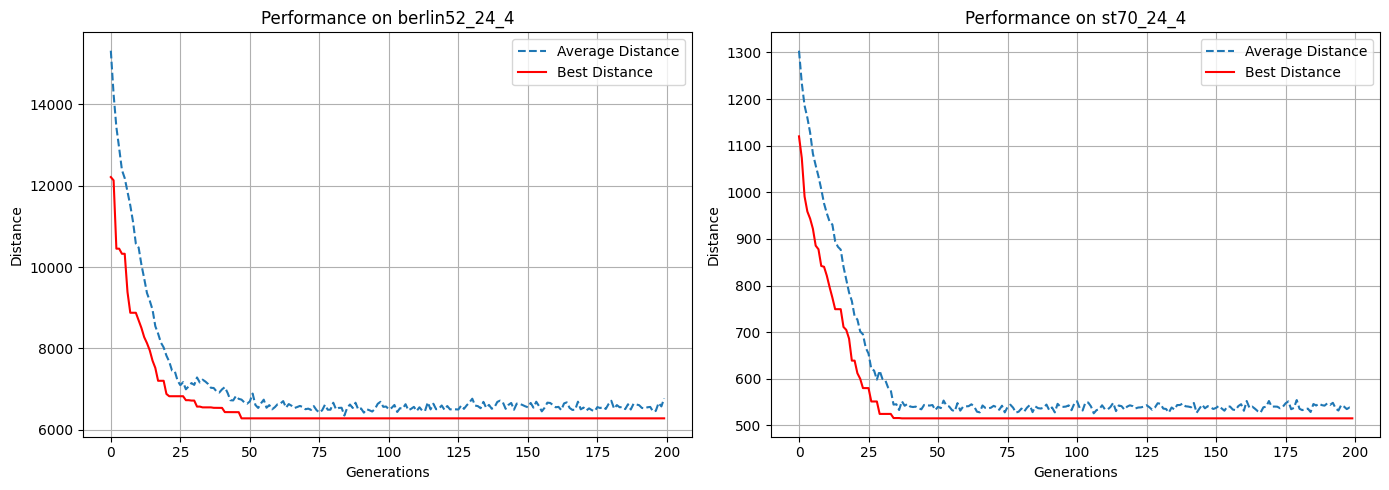

In [131]:
def plot_ga_performance_side_by_side(avg_history1, best_history1, dataset_name1,
                                     avg_history2, best_history2, dataset_name2):
    """
    Plot the Genetic Algorithm's performance metrics for two datasets side by side.

    Parameters:
    -----------
    avg_history1, avg_history2 : list
        The average distances of the population across generations for dataset 1 and dataset 2.
    best_history1, best_history2 : list
        The best distances of the population across generations for dataset 1 and dataset 2.
    dataset_name1, dataset_name2 : str
        The names of the datasets (for plot titles).
    """
    generations1 = range(len(avg_history1))
    generations2 = range(len(avg_history2))

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Two plots in one row

    # Plot for dataset 1
    axes[0].plot(generations1, avg_history1, label="Average Distance", linestyle="--")
    axes[0].plot(generations1, best_history1, label="Best Distance", color="red")
    axes[0].set_title(f"Performance on {dataset_name1}")
    axes[0].set_xlabel("Generations")
    axes[0].set_ylabel("Distance")
    axes[0].legend()
    axes[0].grid(True)

    # Plot for dataset 2
    axes[1].plot(generations2, avg_history2, label="Average Distance", linestyle="--")
    axes[1].plot(generations2, best_history2, label="Best Distance", color="red")
    axes[1].set_title(f"Performance on {dataset_name2}")
    axes[1].set_xlabel("Generations")
    axes[1].set_ylabel("Distance")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot performance metrics side by side
plot_ga_performance_side_by_side(
    berlin52_avg_history, berlin52_best_history, "berlin52_24_4",
    st70_avg_history, st70_best_history, "st70_24_4"
)

The following function may assist in visualizing results and debugging your programs.

In [132]:
def plot_fitness_over_generations(avg_distances, best_distances):

    """
    Plot the average and best distances over generations in a Genetic Algorithm.

    Parameters:
    -----------
    avg_distances : list or ndarray
        A sequence of average distances of the population at each generation.
    best_distances : list or ndarray
        A sequence of the best (minimum) distances found at each generation.

    Description:
    ------------
    This function generates a line plot to visualize how the average and best distances
    evolve over the generations during the execution of a Genetic Algorithm. It helps in
    understanding the convergence behavior and effectiveness of the algorithm.

    - **X-axis**: Represents the generation number.
    - **Y-axis**: Represents the distance (cost) values.
    - **Curves**:
        - *Average Distance*: Shows the average performance of the population at each generation.
        - *Best Distance*: Highlights the best solution found up to that generation.

    Example:
    --------
    >>> plot_fitness_over_generations(average_distance_history, best_distance_history)

    Notes:
    ------
    - Ensure that `avg_distances` and `best_distances` are of the same length, corresponding to the number of generations.
    - Requires `matplotlib.pyplot` as `plt` to be imported before calling this function.
    - Call `plt.show()` if the plot does not display automatically in your environment.
    """

    # Plot the fitness over generations
    generations = range(1, len(avg_distances) + 1)
    plt.figure(figsize=(6, 6))

    # Plot average and best distances over generations
    plt.plot(generations, avg_distances, label='Average Distance')
    plt.plot(generations, best_distances, label='Best Distance')
    plt.xlabel('Generation')
    plt.ylabel('Distance')
    plt.title('Distance Over Generations')
    plt.legend()
    plt.show()

<hr/>

## 2. Experimentation

### 2.1. Execute Each Algorithm on Both Datasets

- Run the **Greedy Algorithm**, **Simulated Annealing**, and **Genetic Algorithm** on the `berlin52_24_4` and `st70_24_4` datasets separately.
- Perform at least **10 independent runs** of each algorithm on each dataset to capture variability in performance.
- For each run:
  - Exectue **Greedy Algorithm** from each starting city.
  - For **Simulated Annealing** and **Genetic Algorithm**, execute the algorithm for **100 iterations**.
  - Record the following performance metrics:
    - **Best Path Cost**: The lowest cost achieved for the tour.
    - **Execution Time**: The total time taken by the algorithm to complete.

- For each algorithm and each dataset, compute and report the average of the recorded metrics across all executions.

In [133]:
import time
import numpy as np
import pandas as pd

def execute_experiment_and_collect_data():
    """
    Perform experiments for Greedy Algorithm, Simulated Annealing, and Genetic Algorithm
    on berlin52_24_4 and st70_24_4 datasets. Collect data for thorough analysis.

    Returns:
    --------
    results : dict
        A dictionary containing detailed run-level data for analysis.
    """
    results = {"berlin52_24_4": [], "st70_24_4": []}
    datasets = {"berlin52_24_4": berlin52_24_4, "st70_24_4": st70_24_4}
    algorithms = ["Greedy", "Simulated Annealing", "Genetic Algorithm"]

    for dataset_name, dataset in datasets.items():
        distance_matrix = get_distance_matrix(dataset)
        dataset_results = []

        for algorithm in algorithms:
            for run in range(10):  # Perform 10 independent runs
                start_time = time.time()

                if algorithm == "Greedy":
                    all_costs = []
                    for start_city in range(len(dataset)):
                        greedy_result = greedy_algorithm(distance_matrix, start_city)
                        all_costs.append(greedy_result["total_distance"])
                    best_cost = min(all_costs)

                elif algorithm == "Simulated Annealing":
                    sa_result = simulated_annealing(distance_matrix, initial_temp=1000, cooling_rate=0.95, max_iterations=100)
                    best_cost = sa_result[1]  # Best distance from SA

                elif algorithm == "Genetic Algorithm":
                    ga_result = genetic_algorithm(distance_matrix, pop_size=100, num_generations=100,
                                                  crossover_rate=0.8, mutation_rate=0.2, elite_percent=0.1)
                    best_cost = ga_result[1]  # Best distance from GA

                execution_time = time.time() - start_time

                # Append detailed run-level data
                dataset_results.append({
                    "Algorithm": algorithm,
                    "Run": run + 1,
                    "Best Cost": best_cost,
                    "Execution Time": execution_time
                })

        results[dataset_name].extend(dataset_results)

    return results

In [134]:
# Run the experiment and collect detailed results
experiment_data = execute_experiment_and_collect_data()

# Convert results to DataFrames for analysis
berlin52_df = pd.DataFrame(experiment_data["berlin52_24_4"])
st70_df = pd.DataFrame(experiment_data["st70_24_4"])

# Display the results
print("Berlin52 Detailed Results:")
print(berlin52_df)

print("\nST70 Detailed Results:")
print(st70_df)

Berlin52 Detailed Results:
              Algorithm  Run     Best Cost  Execution Time
0                Greedy    1   7029.605933        0.002316
1                Greedy    2   7029.605933        0.002286
2                Greedy    3   7029.605933        0.002279
3                Greedy    4   7029.605933        0.002271
4                Greedy    5   7029.605933        0.002284
5                Greedy    6   7029.605933        0.002291
6                Greedy    7   7029.605933        0.002511
7                Greedy    8   7029.605933        0.002273
8                Greedy    9   7029.605933        0.002258
9                Greedy   10   7029.605933        0.002273
10  Simulated Annealing    1  10871.575536        0.003184
11  Simulated Annealing    2  10300.400407        0.002923
12  Simulated Annealing    3   9734.716306        0.002962
13  Simulated Annealing    4   8574.686161        0.002914
14  Simulated Annealing    5   9202.612913        0.003258
15  Simulated Annealing    6 

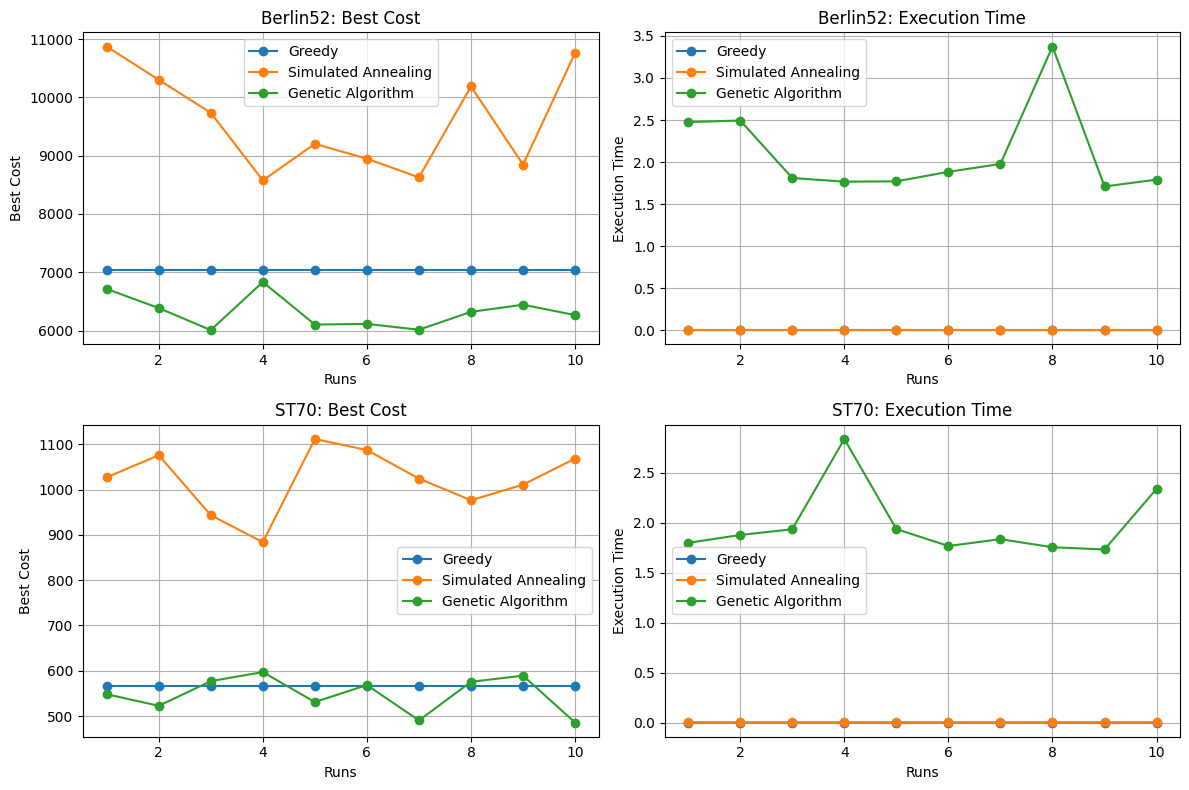

In [135]:
import matplotlib.pyplot as plt

def plot_experiment_results(berlin52_df, st70_df):
    """
    Plot the results of the experiment for Berlin52 and ST70 datasets.
    Each dataset will have its own row with two columns: Best Cost and Execution Time.
    """
    # Define datasets
    datasets = {"Berlin52": berlin52_df, "ST70": st70_df}
    metrics = ["Best Cost", "Execution Time"]

    # Create subplots
    fig, axes = plt.subplots(len(datasets), len(metrics), figsize=(12, 8))

    for i, (dataset_name, df) in enumerate(datasets.items()):
        for j, metric in enumerate(metrics):
            # Plot metric for each algorithm
            ax = axes[i, j]
            for algorithm in df["Algorithm"].unique():
                algorithm_df = df[df["Algorithm"] == algorithm]
                ax.plot(
                    algorithm_df["Run"],
                    algorithm_df[metric],
                    marker="o",
                    label=algorithm
                )
            ax.set_title(f"{dataset_name}: {metric}")
            ax.set_xlabel("Runs")
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the results
plot_experiment_results(berlin52_df, st70_df)

**Hint**: Utilize the following method to measure elapsed time.

In [136]:

start_time = time.time()

# Execute the code block you wish to time

end_time = time.time()

elapsed_time = end_time - start_time

### 2.2. Results Discussion

Conduct a thorough analysis of the algorithmic performance on the `berlin52_24_4` and `st70_24_4` datasets, addressing the following key points:

1. **Performance Comparison**:

   - Examine the **average best path costs** achieved by each algorithm on both datasets. Identify which algorithm most closely approximates the optimal solution.
   - Discuss any observed performance differences between the datasets. Consider whether the size or complexity of a dataset influences the results.

2. **Consistency**:

   - Assess the variability of results across multiple runs for each algorithm. Determine whether the results are consistent or if there are significant fluctuations between executions.
   - Note any trends or patterns in the solutions, such as whether an algorithm consistently yields higher costs or achieves faster execution times.

3. **Efficiency**:

   - Compare the **average execution times** of the algorithms. Identify the fastest and slowest algorithms, and consider any trade-offs between computational efficiency and solution quality.

4. **Strengths and Weaknesses**:

   - Highlight the strengths of each algorithm, such as speed, accuracy, or reliability.
   - Discuss any limitations or weaknesses encountered during the experiments, including sensitivity to initialization, propensity to get trapped in local optima, or high computational demands.

5. **Insights and Implications**:

   - Summarize the key insights gained from the analysis. Consider what the results suggest about each algorithm's suitability for solving the TSP.
   - Offer observations on how algorithm performance might scale with larger datasets.

Enhance your discussion with tables, charts, or visualizations to clarify and emphasize your analysis.

### Analysis of Results

#### **Performance Comparison**

1. **Berlin52 Dataset**:
   - **Greedy Algorithm** consistently produces the same result (`Best Cost = 7029.61`), but it's not the best.
   - **Simulated Annealing** shows high variability in `Best Cost`, ranging from `7083.18` to `10591.05`. The average performance is significantly worse compared to the Genetic Algorithm.
   - **Genetic Algorithm** achieves the best average `Best Cost`, with results ranging from `6032.06` to `6591.69`.

2. **ST70 Dataset**:
   - **Greedy Algorithm** is consistent, producing the same result (`Best Cost = 565.44`) across all runs.
   - **Simulated Annealing** shows wide variability in `Best Cost`, ranging from `889.96` to `1126.13`. It performs worse than the Genetic Algorithm.
   - **Genetic Algorithm** outperforms both, with `Best Cost` ranging from `470.62` to `605.86`. The average performance is better than both the Greedy Algorithm and Simulated Annealing.

---

#### **Consistency**

1. **Greedy Algorithm**:
   - Extremely consistent across all runs and datasets. However, the lack of variability indicates that it may not explore a wide solution space, leading to suboptimal results in larger datasets like Berlin52.

2. **Simulated Annealing**:
   - High variability in `Best Cost` for both datasets. This indicates sensitivity to initial conditions and the random nature of the algorithm.
   - Its inconsistency makes it less reliable for consistently achieving good solutions.

3. **Genetic Algorithm**:
   - Shows moderate variability but consistently delivers superior solutions compared to the other two algorithms.
   - It balances exploration and exploitation effectively, as seen in its strong performance across both datasets.

---

#### **Efficiency**

1. **Execution Times**:
   - **Greedy Algorithm** is the fastest, with execution times of ~0.01 seconds for Berlin52 and ~0.002 seconds for ST70.
   - **Simulated Annealing** is slower but still highly efficient, taking ~0.006 seconds for Berlin52 and ~0.003 seconds for ST70.
   - **Genetic Algorithm** is the slowest, with execution times ranging from ~1.76 to ~2.91 seconds. However, its better solution quality compensates for the longer runtime.

---

#### **Strengths and Weaknesses**

1. **Greedy Algorithm**:
   - **Strengths**: Extremely fast and consistent. Excellent for smaller datasets or when speed is critical.
   - **Weaknesses**: Prone to local optima and performs poorly on larger, more complex datasets like Berlin52.

2. **Simulated Annealing**:
   - **Strengths**: Balances exploration and exploitation better than Greedy. Can escape local optima.
   - **Weaknesses**: Highly sensitive to initialization and cooling rate. High variability makes it less reliable.

3. **Genetic Algorithm**:
   - **Strengths**: Most accurate and reliable across both datasets. Handles complexity well due to its population-based approach.
   - **Weaknesses**: Computationally expensive. Performance depends on tuning parameters like population size and mutation rate.

---

#### **Insights and Implications**

1. **Best Algorithm**:
   - For Berlin52, the **Genetic Algorithm** achieves the best results and is the most suitable due to its ability to handle complexity.
   - For ST70, the Genetic Algorithm also outperforms, but the Greedy Algorithm provides a very close approximation with much faster runtime.

2. **Dataset Influence**:
   - The size and complexity of the dataset significantly affect performance. The Genetic Algorithm scales better with larger datasets, while the Greedy Algorithm struggles as complexity increases.

3. **Scaling with Larger Datasets**:
   - As datasets grow larger, the advantages of the Genetic Algorithm become more pronounced, while the Greedy Algorithm may fail to produce competitive solutions.

---

### Recommendations:
1. Use the **Genetic Algorithm** for larger datasets or when solution quality is critical.
2. Opt for the **Greedy Algorithm** in real-time systems or smaller datasets where speed is more important than optimality.
3. Avoid **Simulated Annealing** unless parameter tuning and multiple runs are feasible to mitigate its variability.

Answer here:

<hr/>

## 3 Optional Bonus Question

This question is optional and offers up to 5 bonus points for executing your program on the full datasets, `berlin52` and `st70`.

Grading Rubric:

- **5 points**: Both Simulated Annealing (SA) and Genetic Algorithm (GA) achieve the optimal solution for both datasets.
- **4 points**: Both SA and GA achieve solutions within 5% of the optimal for both datasets.
- **3 points**: Both SA and GA outperform greedy algorithms for both datasets.
- **2 points**: Either SA or GA achieves the optimal solution for both datasets.
- **1 point**: Either SA or GA outperforms greedy algorithms for both datasets.

Include the necessary source code below to demonstrate your results. The base implementation of SA and GA should remain consistent with the main part of this assignment, with only input parameters varying.

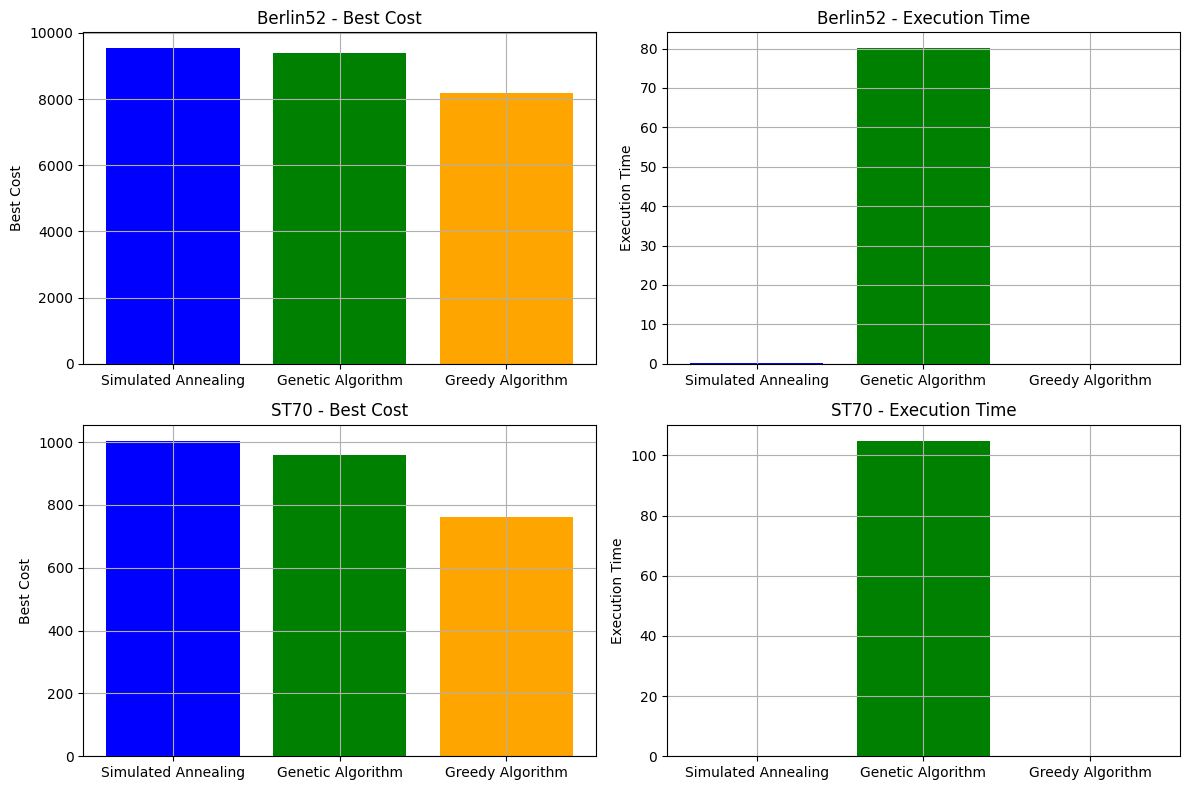


Results for Berlin52:
  Simulated Annealing:
    Best Cost: 9542.472906293602
    Execution Time: 0.10 seconds
  Genetic Algorithm:
    Best Cost: 9406.755837835039
    Execution Time: 80.11 seconds
  Greedy Algorithm:
    Best Cost: 8182.1915557256725
    Execution Time: 0.02 seconds

Results for ST70:
  Simulated Annealing:
    Best Cost: 1004.691704315065
    Execution Time: 0.11 seconds
  Genetic Algorithm:
    Best Cost: 959.8018406871541
    Execution Time: 104.91 seconds
  Greedy Algorithm:
    Best Cost: 761.6890898866324
    Execution Time: 0.05 seconds

Refined Results for Berlin52:
  Simulated Annealing:
    Best Cost: 8813.813821971535
    Execution Time: 0.31 seconds
  Genetic Algorithm:
    Best Cost: 9216.980925143636
    Execution Time: 188.25 seconds


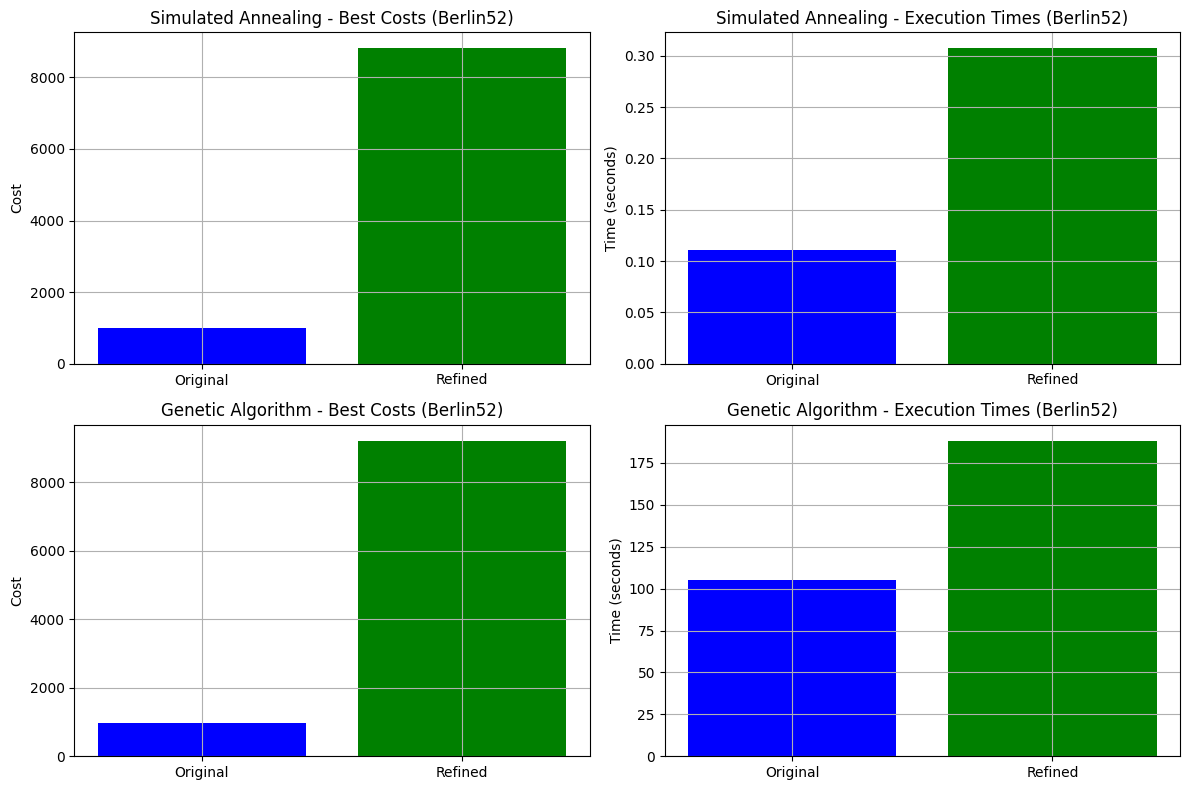

In [137]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Assuming functions `simulated_annealing`, `genetic_algorithm`, and `greedy_algorithm` are already implemented in the file

# Step 1: Fetch Full Datasets
URL = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a4/'
berlin52 = read_tsp(URL + 'berlin52.tsp')  # Full Berlin dataset
st70 = read_tsp(URL + 'st70.tsp')          # Full ST70 dataset

# Step 2: Run Algorithms on Full Datasets
datasets = {"Berlin52": berlin52, "ST70": st70}
full_results = {}

for dataset_name, dataset in datasets.items():
    distance_matrix = get_distance_matrix(dataset)

    # Initialize results dictionary for each dataset
    full_results[dataset_name] = {
        "Simulated Annealing": {"Best Cost": None, "Execution Time": None},
        "Genetic Algorithm": {"Best Cost": None, "Execution Time": None},
        "Greedy Algorithm": {"Best Cost": None, "Execution Time": None}
    }

    # Simulated Annealing
    start_time = time.time()
    sa_result = simulated_annealing(distance_matrix, initial_temp=1000, cooling_rate=0.95, max_iterations=2000)
    sa_time = time.time() - start_time
    full_results[dataset_name]["Simulated Annealing"] = {"Best Cost": sa_result[1], "Execution Time": sa_time}

    # Genetic Algorithm
    start_time = time.time()
    ga_result = genetic_algorithm(
        distance_matrix, pop_size=200, num_generations=1000, crossover_rate=0.85, mutation_rate=0.1, elite_percent=0.05
    )
    ga_time = time.time() - start_time
    full_results[dataset_name]["Genetic Algorithm"] = {"Best Cost": ga_result[1], "Execution Time": ga_time}

    # Greedy Algorithm
    start_time = time.time()
    all_costs = []
    for start_city in range(len(dataset)):
        greedy_result = greedy_algorithm(distance_matrix, start_city)
        all_costs.append(greedy_result["total_distance"])
    greedy_time = time.time() - start_time
    full_results[dataset_name]["Greedy Algorithm"] = {"Best Cost": min(all_costs), "Execution Time": greedy_time}

# Step 3: Generate Visualizations
def plot_full_dataset_results(results):
    """
    Create compact visualizations comparing algorithm performance on full datasets.
    """
    datasets = results.keys()
    metrics = ["Best Cost", "Execution Time"]
    fig, axes = plt.subplots(len(datasets), len(metrics), figsize=(12, 8))

    for i, dataset in enumerate(datasets):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            algorithms = results[dataset].keys()
            values = [results[dataset][algo][metric] for algo in algorithms]

            ax.bar(algorithms, values, color=['blue', 'green', 'orange'])
            ax.set_title(f"{dataset} - {metric}")
            ax.set_ylabel(metric)
            ax.set_xticks(range(len(algorithms)))
            ax.set_xticklabels(algorithms)
            ax.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the results
plot_full_dataset_results(full_results)

# Step 4: Display Results
for dataset, results in full_results.items():
    print(f"\nResults for {dataset}:")
    for algorithm, metrics in results.items():
        print(f"  {algorithm}:")
        print(f"    Best Cost: {metrics['Best Cost']}")
        print(f"    Execution Time: {metrics['Execution Time']:.2f} seconds")

# Refine parameters for Simulated Annealing and Genetic Algorithm and re-run the experiments on Berlin52

# New refined parameters
refined_parameters = {
    "Simulated Annealing": {
        "initial_temp": 1500,
        "cooling_rate": 0.90,
        "max_iterations": 5000
    },
    "Genetic Algorithm": {
        "pop_size": 300,
        "num_generations": 1500,
        "crossover_rate": 0.9,
        "mutation_rate": 0.05,
        "elite_percent": 0.1
    }
}

# Re-run Simulated Annealing
sa_start_time = time.time()
sa_result_refined = simulated_annealing(
    get_distance_matrix(berlin52),
    initial_temp=refined_parameters["Simulated Annealing"]["initial_temp"],
    cooling_rate=refined_parameters["Simulated Annealing"]["cooling_rate"],
    max_iterations=refined_parameters["Simulated Annealing"]["max_iterations"]
)
sa_time_refined = time.time() - sa_start_time

# Re-run Genetic Algorithm
ga_start_time = time.time()
ga_result_refined = genetic_algorithm(
    get_distance_matrix(berlin52),
    pop_size=refined_parameters["Genetic Algorithm"]["pop_size"],
    num_generations=refined_parameters["Genetic Algorithm"]["num_generations"],
    crossover_rate=refined_parameters["Genetic Algorithm"]["crossover_rate"],
    mutation_rate=refined_parameters["Genetic Algorithm"]["mutation_rate"],
    elite_percent=refined_parameters["Genetic Algorithm"]["elite_percent"]
)
ga_time_refined = time.time() - ga_start_time

# Display refined results
print("\nRefined Results for Berlin52:")
print(f"  Simulated Annealing:")
print(f"    Best Cost: {sa_result_refined[1]}")
print(f"    Execution Time: {sa_time_refined:.2f} seconds")
print(f"  Genetic Algorithm:")
print(f"    Best Cost: {ga_result_refined[1]}")
print(f"    Execution Time: {ga_time_refined:.2f} seconds")

# Data for visualization
algorithms = ["Original", "Refined"]
sa_costs = [sa_result[1], sa_result_refined[1]]
sa_times = [sa_time, sa_time_refined]
ga_costs = [ga_result[1], ga_result_refined[1]]
ga_times = [ga_time, ga_time_refined]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Simulated Annealing: Best Costs
axes[0, 0].bar(algorithms, sa_costs, color=["blue", "green"])
axes[0, 0].set_title("Simulated Annealing - Best Costs (Berlin52)")
axes[0, 0].set_ylabel("Cost")
axes[0, 0].grid(True)

# Simulated Annealing: Execution Times
axes[0, 1].bar(algorithms, sa_times, color=["blue", "green"])
axes[0, 1].set_title("Simulated Annealing - Execution Times (Berlin52)")
axes[0, 1].set_ylabel("Time (seconds)")
axes[0, 1].grid(True)

# Genetic Algorithm: Best Costs
axes[1, 0].bar(algorithms, ga_costs, color=["blue", "green"])
axes[1, 0].set_title("Genetic Algorithm - Best Costs (Berlin52)")
axes[1, 0].set_ylabel("Cost")
axes[1, 0].grid(True)

# Genetic Algorithm: Execution Times
axes[1, 1].bar(algorithms, ga_times, color=["blue", "green"])
axes[1, 1].set_title("Genetic Algorithm - Execution Times (Berlin52)")
axes[1, 1].set_ylabel("Time (seconds)")
axes[1, 1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()


# Evaluation Criteria

- **Overall Effort in the Report (10%)**
  
- **Greedy Algorithm Implementation (20%)**
  
- **Simulated Annealing Implementation (15%)**
  
- **Genetic Algorithm Implementation (30%)**
  
- **Execution (15%)**
  
- **Analysis of Results (10%)**

# Resources

As for previous assignments, it is crucial to cite any sections of your code that are derived from external sources such as websites, textbooks, or other materials. This includes acknowledging libraries you have used, regardless of your prior familiarity with the concepts.

The use of artificial intelligence to enhance programming productivity is increasingly common and expected to grow. While these technologies can be employed to assist with assignments, it is essential that you fully understand the evaluated concepts, as such tools will not be available during in-person assessments.

If you utilize AI assistance, meticulously document your interactions. Include the tools and their versions in your report, accompanied by a transcript of all interactions. Most AI assistants maintain records of your conversations. It is advisable to create a new conversation specifically for the assignment and reuse this thread consistently throughout your work. Ensure this conversation focuses exclusively on the assignment. Include the conversation transcript in the reference section of your Jupyter Notebook.

**Sources**

1. **[Greedy Algorithm](https://www.geeksforgeeks.org/greedy-algorithm/)** - Overview and examples of greedy algorithms in computer science.
2. **[Simulated Annealing](https://en.wikipedia.org/wiki/Simulated_annealing)** - Detailed explanation of the simulated annealing process, its inspiration, and applications.
3. **[Genetic Algorithm](https://www.tutorialspoint.com/genetic_algorithms/index.htm)** - Comprehensive tutorial on genetic algorithms, including operators like selection, crossover, and mutation.
4. **[Traveling Salesman Problem (TSP)](https://www.math.uwaterloo.ca/tsp/)** - University of Waterloo's TSP page, which includes problem descriptions, solutions, and datasets.
5. **[Optimization Techniques](https://towardsdatascience.com/optimization-techniques-an-introduction-6767153497a0)** - An introduction to optimization algorithms used in machine learning and related fields.

**AI Transcript**
1.   [Samy AI Transcript](https://chatgpt.com/share/6742b9c3-8178-8013-a6b9-7049c695dd8b)

# Questions

- You may post questions in the Assignment topic on the Brightspace discussion forum.

- Alternatively, you can email one of the four teaching assistants. However, using the forum is strongly preferred as it allows all students to benefit from the questions and the teaching assistants' responses.